<a href="https://colab.research.google.com/github/MauricioTellezNava/viropolitica_poblacionCDMX/blob/main/maquetando_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Formando clusters con los datos de la población contagiada de la Ciudad de México

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Exploración

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Análisis del COVID-19 para la Ciudad de México/población/covid_cdmx.csv")
df = df.drop(columns=["Unnamed: 0"])
df.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OTRO_CASO,TOMA_MUESTRA_LAB,RESULTADO_LAB,TOMA_MUESTRA_ANTIGENO,RESULTADO_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI
0,2021-10-31,z13788,1,12,9,1,9,9,4,1,...,1,1,1,2,97,3,99,México,97,97
1,2021-10-31,z526b3,2,12,9,1,9,9,12,1,...,1,2,97,1,1,3,99,México,97,97
2,2021-10-31,z3d1e2,2,12,9,1,9,9,5,1,...,1,1,1,2,97,3,99,México,97,97
3,2021-10-31,zz9079,2,12,9,1,9,9,7,1,...,1,2,97,2,97,1,99,México,97,97
4,2021-10-31,z2770b,1,12,9,1,9,9,6,1,...,1,1,1,2,97,3,99,México,97,97


In [4]:
print(df.shape)
df["FECHA_INGRESO"].sort_values()

(1752242, 40)


309        2020-02-27
310        2020-02-27
13         2020-03-03
8          2020-03-04
11         2020-03-04
              ...    
1751913    2022-11-21
1751912    2022-11-21
1751911    2022-11-21
1751920    2022-11-21
1751915    2022-11-21
Name: FECHA_INGRESO, Length: 1752242, dtype: object

In [5]:
df["FECHA_INGRESO"].value_counts()

2022-01-12    17750
2022-01-14    16888
2022-01-17    16828
2022-01-11    16746
2022-01-19    16693
              ...  
2020-03-07        2
2020-03-09        2
2020-02-27        2
2020-03-03        1
2020-03-06        1
Name: FECHA_INGRESO, Length: 995, dtype: int64

In [6]:
df["NACIONALIDAD"].value_counts()

1    1743571
2       8671
Name: NACIONALIDAD, dtype: int64

In [7]:
df.columns

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')

In [8]:
df["TIPO_PACIENTE"].value_counts()

1    1656581
2      95661
Name: TIPO_PACIENTE, dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1752242 entries, 0 to 1752241
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

# Antes de implementar K-means es necesario convertir a dummy las variables categóricas
## Objetivos
* Identificar y eliminar variables irrelevantes
* Crear un nuevo dataset con el resto de variables categóricas convertidas en variables dummy

In [10]:
# Locaciones

print("Número de entidades de nacimiento de los pacientes: ", len(df["ENTIDAD_NAC"].value_counts()))
print("Número de entidades donde se brindó asistencia médica: ", len(df["ENTIDAD_UM"].value_counts()))
print("Número de entidades de residencia de los pacientes: ", len(df["ENTIDAD_RES"].value_counts()))

# Quzás es necesario eliminar las tres variables, dado que no aportan información relevante sobre la salud de los pacientes.
# Todos tienen residencia en la CDMX, por lo que esta variable también es intrascendente.

Número de entidades de nacimiento de los pacientes:  33
Número de entidades donde se brindó asistencia médica:  32
Número de entidades de residencia de los pacientes:  1


In [11]:
# Fechas  

print("Número de fechas de actualización: ", len(df["FECHA_ACTUALIZACION"].unique()))
print("Número de fechas de inicio de síntomas: ", len(df["FECHA_SINTOMAS"].unique()))
print("Número de fechas de ingreso: ", len(df["FECHA_INGRESO"].unique()))
print("Número de fechas de defunciones: ", len(df["FECHA_DEF"].unique()))

# Las fechas de actualización son irrelevantes
# Las fechas de defunciones son un indicador para la gravedad de la viropolítica
# La diferencia entre las fechas de ingreso menos las fechas de síntomas podría indicar la rapidez en el deterioro de la salud

Número de fechas de actualización:  3
Número de fechas de inicio de síntomas:  1000
Número de fechas de ingreso:  995
Número de fechas de defunciones:  902


In [12]:
# Para la implementación de k-means, sería preciso eliminar momentáneamente las fechas "FECHA_SINTOMAS", "FECHA_INGRESO", "FECHA_DEF" en el dataset X, que tendría solamente variables dummy.

df[["FECHA_SINTOMAS", "FECHA_INGRESO", "FECHA_DEF"]].head()

,FECHA_SINTOMAS,FECHA_INGRESO,FECHA_DEF
0,2020-09-23,2020-09-23,9999-99-99
1,2020-12-18,2020-12-21,9999-99-99
2,2020-04-20,2020-04-22,9999-99-99
3,2020-10-06,2020-10-07,9999-99-99
4,2020-09-03,2020-09-08,9999-99-99


In [13]:
# Sería conveniente incluir la variable "FECHA_DEF" como variable dummy, dónde eñ valor "9999-99-99" es igual al 0, y cualquier otro valor es igual a 1.
df["FECHA_DEF"].value_counts()

9999-99-99    1708625
2021-01-26        270
2021-01-25        261
2021-01-19        253
2021-01-20        243
               ...   
2022-05-18          1
2022-05-19          1
2022-05-14          1
2022-06-06          1
2022-11-18          1
Name: FECHA_DEF, Length: 902, dtype: int64

In [14]:
# Es conveniente eliminar la variable "ID_REGISTRO"
len(df["ID_REGISTRO"].unique())

1752242

In [15]:
# IMPORTANTE eliminar observaciones de nacionalidad extranjera
df["NACIONALIDAD"].value_counts()

1    1743571
2       8671
Name: NACIONALIDAD, dtype: int64

In [16]:
# La columna origen no es relevante
df["ORIGEN"].value_counts()

2    1523240
1     229002
Name: ORIGEN, dtype: int64

In [17]:
# Esta variedad de nacionalidades se evitará cuando se eliminen los valores "NACIONALIDAD" == 2
# Eliminar, además, esta variable
df["PAIS_NACIONALIDAD"].value_counts()

México                       1743572
Estados Unidos de América       1645
Venezuela                       1558
Colombia                         935
Argentina                        381
                              ...   
Egipto                             1
Etiopía                            1
Yemen Democrática                  1
Thailandia                         1
Mongolia                           1
Name: PAIS_NACIONALIDAD, Length: 123, dtype: int64

In [18]:
# Eliminar variable
df["PAIS_ORIGEN"].value_counts()

97                           1750993
Venezuela                        282
Colombia                         144
Estados Unidos de América        116
China                             91
                              ...   
Myanmar                            1
Nigeria                            1
Grecia                             1
Pakistán                           1
Bangladesh                         1
Name: PAIS_ORIGEN, Length: 71, dtype: int64

In [19]:
#Resultados
# Dado que todos los valores indican que el status de COVID-19 es positivo, se debe eliminar esta columna.
print("Casos positivos", "\n", df["CLASIFICACION_FINAL"].value_counts())
print("¿Al paciente se le tomó la muestra de antígeno?", "\n", df["TOMA_MUESTRA_ANTIGENO"].value_counts())
print("Resultado del análisis de la muestra de antígeno", "\n", df["RESULTADO_ANTIGENO"].value_counts())
print("¿Al paciente se le tomó la muestra de laboratorio?", "\n", df["TOMA_MUESTRA_LAB"].value_counts())
print("Resultado de la muestra de laboratorio", "\n", df["RESULTADO_LAB"].value_counts())
# Eliminar también las columnas "RESULTADO_ANTIGENO", "RESULTADO_LAB", "TOMA_MUESTRA_ANTIGENO" y "TOMA_MUESTRA_LAB".

Casos positivos 
 3    1537505
1     211381
2       3356
Name: CLASIFICACION_FINAL, dtype: int64
¿Al paciente se le tomó la muestra de antígeno? 
 1    1393134
2     359108
Name: TOMA_MUESTRA_ANTIGENO, dtype: int64
Resultado del análisis de la muestra de antígeno 
 1     1160179
97     359108
2      232955
Name: RESULTADO_ANTIGENO, dtype: int64
¿Al paciente se le tomó la muestra de laboratorio? 
 2    1326740
1     425502
Name: TOMA_MUESTRA_LAB, dtype: int64
Resultado de la muestra de laboratorio 
 97    1326740
1      408235
4       13682
2        3569
3          16
Name: RESULTADO_LAB, dtype: int64


In [20]:
# Esta variable puede ser la clave para distinguir a los individuos que ejercen más la viropolítica de los que la más la adolecen
df["TIPO_PACIENTE"].value_counts()

1    1656581
2      95661
Name: TIPO_PACIENTE, dtype: int64

In [21]:
# También da cuenta de la viropolítica
df["UCI"].value_counts()

97    1656581
2       89411
1        6125
99        125
Name: UCI, dtype: int64

## Resultados

## Filas por eliminar
- NACIONALIDAD == 2

## Columnas por eliminar:
- ENTIDAD_NAC
- ENTIDAD_UM
- ENTIDAD_RES
- FECHA_ACTUALIZACION
- FECHA_SINTOMAS
- FECHA_INGRESO
- ID_REGISTRO
- ORIGEN
- PAIS_NACIONALIDAD
- PAIS_ORIGEN
- CLASIFICACION_FINAL
- RESULTADO_ANTIGENO
- RESULTADO_LAB 
- TOMA_MUESTRA_ANTIGENO
- TOMA_MUESTRA_LAB

## Columnas por modificar:
- FECHA_DEF

In [22]:
# Eliminando nacionalidad extranjera (2)
df2 = df[df["NACIONALIDAD"]==1]
print(df2.shape)
df2["PAIS_NACIONALIDAD"].value_counts()

(1743571, 40)


México    1743571
Name: PAIS_NACIONALIDAD, dtype: int64

In [23]:
# Eliminando columnas
print(df2.columns)
df2 = df2.drop(columns=["ENTIDAD_NAC", "ENTIDAD_UM", "ENTIDAD_RES", "FECHA_ACTUALIZACION", "FECHA_SINTOMAS", "FECHA_INGRESO", "ID_REGISTRO", "ORIGEN", "PAIS_NACIONALIDAD", "PAIS_ORIGEN", "CLASIFICACION_FINAL", "RESULTADO_ANTIGENO",
"RESULTADO_LAB", "TOMA_MUESTRA_ANTIGENO", "TOMA_MUESTRA_LAB"])
print(df2.columns)
df2.shape

Index(['FECHA_ACTUALIZACION', 'ID_REGISTRO', 'ORIGEN', 'SECTOR', 'ENTIDAD_UM',
       'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES', 'MUNICIPIO_RES', 'TIPO_PACIENTE',
       'FECHA_INGRESO', 'FECHA_SINTOMAS', 'FECHA_DEF', 'INTUBADO', 'NEUMONIA',
       'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'TOMA_MUESTRA_LAB', 'RESULTADO_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'RESULTADO_ANTIGENO', 'CLASIFICACION_FINAL',
       'MIGRANTE', 'PAIS_NACIONALIDAD', 'PAIS_ORIGEN', 'UCI'],
      dtype='object')
Index(['SECTOR', 'SEXO', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'FECHA_DEF',
       'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD', 'EMBARAZO',
       'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', '

(1743571, 25)

In [24]:
df2.head()

,SECTOR,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,FECHA_DEF,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,...,INMUSUPR,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI
0,12,1,4,1,9999-99-99,97,2,67,1,2,...,2,2,2,2,2,2,2,1,99,97
1,12,1,12,1,9999-99-99,97,2,62,1,2,...,2,1,2,2,1,2,2,1,99,97
2,12,1,5,1,9999-99-99,97,2,45,1,2,...,2,2,2,2,1,2,2,1,99,97
3,12,1,7,1,9999-99-99,97,2,38,1,2,...,2,2,2,2,2,2,2,1,99,97
4,12,1,6,1,9999-99-99,97,2,26,1,2,...,2,2,2,2,2,2,2,1,99,97


In [25]:
# Creando una columna para las defunciones con valores dummy, a partir de "FECHA_DEF"
# Casos donde no hubo defunciones: df2["FECHA_DEF"] =  "9999-99-99"
# Tiene datos tipo object/ string
print("Tipo de dato: ", df2["FECHA_DEF"].dtype)
df2["FECHA_DEF"].value_counts()

Tipo de dato:  object


9999-99-99    1700058
2021-01-26        269
2021-01-25        260
2021-01-19        253
2021-01-20        243
               ...   
2022-06-09          1
2022-05-18          1
2022-05-19          1
2022-06-06          1
2022-11-18          1
Name: FECHA_DEF, Length: 902, dtype: int64

In [26]:
# Hay la misma cantidad de valores para 9999-99-99 que para 0, es decir,  1700058
df2["defunciones"] = np.where(df2["FECHA_DEF"]== "9999-99-99", 0, 1)
print("Número de valores para '9999-99-99': ", df2["FECHA_DEF"].value_counts())
print("Número de valores para 0: ", df2["defunciones"].value_counts())
print("La cantidad de valores para 9999-99-99 y para 0 debe ser la misma")
df2[["FECHA_DEF", "defunciones"]].head(7)

Número de valores para '9999-99-99':  9999-99-99    1700058
2021-01-26        269
2021-01-25        260
2021-01-19        253
2021-01-20        243
               ...   
2022-06-09          1
2022-05-18          1
2022-05-19          1
2022-06-06          1
2022-11-18          1
Name: FECHA_DEF, Length: 902, dtype: int64
Número de valores para 0:  0    1700058
1      43513
Name: defunciones, dtype: int64
La cantidad de valores para 9999-99-99 y para 0 debe ser la misma


,FECHA_DEF,defunciones
0,9999-99-99,0
1,9999-99-99,0
2,9999-99-99,0
3,9999-99-99,0
4,9999-99-99,0
5,9999-99-99,0
6,9999-99-99,0


In [27]:
# Ahora ya podemos eliminar "FECHA_DEF"
# Todas las variables son números enteros
df3 = df2.drop(columns=["FECHA_DEF"])
print(df3.columns)
df3.head()

Index(['SECTOR', 'SEXO', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'INTUBADO',
       'NEUMONIA', 'EDAD', 'NACIONALIDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG',
       'INDIGENA', 'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION',
       'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'MIGRANTE', 'UCI', 'defunciones'],
      dtype='object')


,SECTOR,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI,defunciones
0,12,1,4,1,97,2,67,1,2,2,...,2,2,2,2,2,2,1,99,97,0
1,12,1,12,1,97,2,62,1,2,2,...,1,2,2,1,2,2,1,99,97,0
2,12,1,5,1,97,2,45,1,2,2,...,2,2,2,1,2,2,1,99,97,0
3,12,1,7,1,97,2,38,1,2,2,...,2,2,2,2,2,2,1,99,97,0
4,12,1,6,1,97,2,26,1,2,2,...,2,2,2,2,2,2,1,99,97,0


In [28]:
# Eliminando los valores "MUNICIPIO_RES" = 106 de df3
# Obteniendo los indices
print("Dimensiones iniciales de df3: ", df3.shape)
print(df3[df3["MUNICIPIO_RES"]==106].index)
df3[df3["MUNICIPIO_RES"]==106]

Dimensiones iniciales de df3:  (1743571, 25)
Int64Index([19885, 20280, 20655], dtype='int64')


,SECTOR,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI,defunciones
19885,12,1,106,1,97,2,26,1,2,2,...,2,2,2,2,2,2,1,99,97,0
20280,11,2,106,1,97,2,25,1,97,2,...,2,2,2,2,2,2,2,99,97,0
20655,12,1,106,1,97,2,30,1,2,2,...,2,2,2,2,2,2,1,99,97,0


In [29]:
df3 = df3.drop([19885, 20280, 20655])
print("Dimensiones finales de df3: ", df3.shape)


Dimensiones finales de df3:  (1743568, 25)


In [30]:
# Prueba
# Resultado exitoso
df3[df3["MUNICIPIO_RES"]==106]

,SECTOR,SEXO,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,EDAD,NACIONALIDAD,EMBARAZO,HABLA_LENGUA_INDIG,...,HIPERTENSION,OTRA_COM,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,MIGRANTE,UCI,defunciones


In [31]:
# Eliminando la columna NACIONALIDAD
df3 = df3.drop(columns=["NACIONALIDAD"])


In [32]:
# Eliminando la columna MIGRANTE
df3 = df3.drop(columns=["MIGRANTE"])

In [33]:
df3.columns

Index(['SECTOR', 'SEXO', 'MUNICIPIO_RES', 'TIPO_PACIENTE', 'INTUBADO',
       'NEUMONIA', 'EDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'INDIGENA',
       'DIABETES', 'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'UCI', 'defunciones'],
      dtype='object')

# Convirtiendo todas las variables dummies (menos "defunciones").
## (¿Habría que obtener y después unir 25 dataframes?)

In [34]:
# Ejercicio
# Para unir los datasets basta con concatenarlos de la siguiente manera
# pd.concat([sexo, tipo_paciente], axis = 1)

In [35]:
# SECTOR
sector = pd.get_dummies(df3["SECTOR"], prefix = "inst")
sector.shape

(1743568, 14)

In [36]:
# SEXO
sexo = pd.get_dummies(df3["SEXO"], prefix = "sex")
sexo = sexo.rename({"sex_1":"sex_M", "sex_2":"sex_H"}, axis="columns")
sexo.shape

(1743568, 2)

In [37]:
# MUNICIPIO_RES
alcaldias = pd.get_dummies(df3["MUNICIPIO_RES"], prefix = "alc")
alcaldias = alcaldias.rename({"alc_2" : "alc_azcap", "alc_3" : "alc_coyo", "alc_4" : "alc_cuaj", "alc_5" : "alc_gam", "alc_6" : "alc_iztac", "alc_7" : "alc_iztap", "alc_8" : "alc_magdC", "alc_9" : "alc_milpa", "alc_10" : "alc_alv", 
                              "alc_11" : "alc_tlah", "alc_12" : "alc_tlalp", "alc_13" : "alc_xoch", "alc_14" : "alc_beniJ", 
                              "alc_15" : "alc_cuauh", "alc_16" : "alc_migH", "alc_17" : "venusC", "alc_999" : "alc_noEsp"}, axis = "columns")
alcaldias.shape

(1743568, 17)

In [38]:
# TIPO_PACIENTE
tipo_paciente = pd.get_dummies(df3["TIPO_PACIENTE"], prefix = "paciente")
tipo_paciente = tipo_paciente.rename({"paciente_1" : "paciente_amb", "paciente_2" : "paciente_hosp"}, axis = "columns")
tipo_paciente.shape

(1743568, 2)

In [39]:
# INTUBADO
intubado = pd.get_dummies(df3["INTUBADO"], prefix="intub")
intubado = intubado.rename({"intub_1" : "intub_si", "intub_2" : "intub_no", "intub_97" : "intub_noAplica", "intub_99" : "intub_noEsp"}, axis="columns")
intubado.shape

(1743568, 4)

In [40]:
# NEUMONIA
neumonia = pd.get_dummies(df3["NEUMONIA"], prefix="neumonia")
neumonia = neumonia.rename({"neumonia_1" : "neumonia_si", "neumonia_2" : "neumonia_no", "neumonia_99" : "neumonia_noEsp"}, axis = "columns")
neumonia.shape


(1743568, 3)

In [41]:
# EDAD
# Se decidió dejar la columna EDAD intacta
# Evaluar si esta decisión distorsiona el modelo K-means
edad = df3[["EDAD"]]
edad.shape

(1743568, 1)

In [42]:
# EMBARAZO
embarazo =  pd.get_dummies(df3["EMBARAZO"], prefix="embarazo")
embarazo = embarazo.rename({"embarazo_1":"embarazo_si", "embarazo_2":"embarazo_no", "embarazo_97":"embarazo_noAplica", "embarazo_98":"embarazo_seIgn"}, axis = "columns")
embarazo.shape

(1743568, 4)

In [43]:
# HABLA_LENGUA_INDIG
leng_ind = pd.get_dummies(df3["HABLA_LENGUA_INDIG"], prefix="leng_ind")
leng_ind = leng_ind.rename({"leng_ind_1" : "leng_ind_si", "leng_ind_2" : "leng_ind_no", "leng_ind_99" : "leng_ind_noEsp"}, axis = "columns")
leng_ind.shape

(1743568, 3)

In [44]:
# INDIGENA
indigena = pd.get_dummies(df3["INDIGENA"], prefix="indigena")
indigena = indigena.rename({"indigena_1":"indigena_si", "indigena_2":"indigena_no", "indigena_99":"indigena_noEsp"}, axis = "columns")
indigena.shape

(1743568, 3)

In [45]:
# DIABETES
diabetes = pd.get_dummies(df3["DIABETES"], prefix = "diabetes")
diabetes = diabetes.rename({"diabetes_1":"diabetes_si", "diabetes_2":"diabetes_no", "diabetes_98":"diabetes_seIgn"}, axis="columns")
diabetes.shape

(1743568, 3)

In [46]:
# EPOC
epoc = pd.get_dummies(df3["EPOC"], prefix="epoc")
epoc = epoc.rename({"epoc_1" : "epoc_si", "epoc_2" : "epoc_no", "epoc_98" : "epoc_seIgn"}, axis="columns")
epoc.shape

(1743568, 3)

In [47]:
# ASMA
asma = pd.get_dummies(df3["ASMA"], prefix="asma")
asma = asma.rename({"asma_1" : "asma_si", "asma_2" : "asma_no", "asma_98" : "asma_seIgn"}, axis="columns")
asma.shape

(1743568, 3)

In [48]:
# INMUSUPR
inmusupr = pd.get_dummies(df3["INMUSUPR"], prefix = "inmusupr")
inmusupr = inmusupr.rename({"inmusupr_1":"inmusupr_si", "inmusupr_2":"inmusupr_no", "inmusupr_98":"inmusupr_seIgn"}, axis="columns")
inmusupr.shape

(1743568, 3)

In [49]:
# HIPERTENSION
hipertension = pd.get_dummies(df3["HIPERTENSION"], prefix="hipert")
hipertension = hipertension.rename({"hipert_1":"hipert_si", "hipert_2":"hipert_no", "hipert_98":"hipert_seIgn"}, axis="columns")
hipertension.shape

(1743568, 3)

In [50]:
# OTRA_COM
otra_com = pd.get_dummies(df3["OTRA_COM"], prefix = "otr_com")
otra_com = otra_com.rename({"otr_com_1":"otr_com_si", "otr_com_2":"otr_com_no", "otr_com_98":"otr_com_seIgn"}, axis="columns")
otra_com.shape

(1743568, 3)

In [51]:
# CARDIOVASCULAR
cardio = pd.get_dummies(df3["CARDIOVASCULAR"], prefix="cardio")
cardio = cardio.rename({"cardio_1":"cardio_si", "cardio_2":"cardio_no", "cardio_98":"cardio_seIgn"}, axis="columns")
cardio.shape

(1743568, 3)

In [52]:
# OBESIDAD
obesidad = pd.get_dummies(df3["OBESIDAD"], prefix="obesidad")
obesidad = obesidad.rename({"obesidad_1":"obesidad_si", "obesidad_2":"obesidad_no", "obesidad_98":"obesidad_seIgn"}, axis="columns")
obesidad.shape

(1743568, 3)

In [53]:
# RENAL_CRONICA
renal_cronica = pd.get_dummies(df3["RENAL_CRONICA"], prefix="renalCr")
renal_cronica = renal_cronica.rename({"renalCr_1":"renalCr_si", "renalCr_2":"renalCr_no", "renalCr_98":"renalCr_seIgn"}, axis="columns")
renal_cronica.shape

(1743568, 3)

In [54]:
# TABAQUISMO
tabaquismo = pd.get_dummies(df3["TABAQUISMO"], prefix="tabaq")
tabaquismo = tabaquismo.rename({"tabaq_1":"tabaq_si", "tabaq_2":"tabaq_no", "tabaq_98":"tabaq_seIgn"}, axis="columns")
tabaquismo.shape

(1743568, 3)

In [55]:
# OTRO_CASO
otro_caso = pd.get_dummies(df3["OTRO_CASO"], prefix="otr_caso")
otro_caso = otro_caso.rename({"otr_caso_1":"otr_caso_si", "otr_caso_2":"otr_caso_no", "otr_caso_99":"otr_caso_seIgn"}, axis="columns")
otro_caso.shape

(1743568, 3)

In [56]:
# UCI
uci = pd.get_dummies(df3["UCI"], prefix="uci")
uci = uci.rename({"uci_1":"uci_si", "uci_2":"uci_no", "uci_97":"uci_noAplica", "uci_99":"uci_noEsp"}, axis="columns")
uci.shape

(1743568, 4)

In [57]:
# defunciones
defunciones = df3[["defunciones"]]
defunciones.shape

(1743568, 1)

# Concatenando los 23 dataframes en el dataframe df4

In [58]:
X = pd.concat([sector, sexo, alcaldias, tipo_paciente, intubado, neumonia, edad, embarazo, leng_ind, indigena, diabetes, epoc, asma, inmusupr, hipertension, otra_com, cardio, obesidad, renal_cronica, tabaquismo, otro_caso, uci, defunciones], axis=1)
X

,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,inst_10,...,tabaq_no,tabaq_seIgn,otr_caso_si,otr_caso_no,otr_caso_seIgn,uci_si,uci_no,uci_noAplica,uci_noEsp,defunciones
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752237,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1752238,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1752239,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
1752240,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0


# Creando el dataframe X

In [59]:
# X = df.drop(columns=["FECHA_ACTUALIZACION", "ID_REGISTRO", "ENTIDAD_RES", "FECHA_INGRESO", "FECHA_SINTOMAS", "FECHA_DEF", "PAIS_NACIONALIDAD", "PAIS_ORIGEN"])
X.head()

,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,inst_10,...,tabaq_no,tabaq_seIgn,otr_caso_si,otr_caso_no,otr_caso_seIgn,uci_si,uci_no,uci_noAplica,uci_noEsp,defunciones
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,1,0,0


In [60]:
X.columns

Index(['inst_1', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7',
       'inst_8', 'inst_9', 'inst_10', 'inst_11', 'inst_12', 'inst_13',
       'inst_14', 'sex_M', 'sex_H', 'alc_azcap', 'alc_coyo', 'alc_cuaj',
       'alc_gam', 'alc_iztac', 'alc_iztap', 'alc_magdC', 'alc_milpa',
       'alc_alv', 'alc_tlah', 'alc_tlalp', 'alc_xoch', 'alc_beniJ',
       'alc_cuauh', 'alc_migH', 'venusC', 'alc_noEsp', 'paciente_amb',
       'paciente_hosp', 'intub_si', 'intub_no', 'intub_noAplica',
       'intub_noEsp', 'neumonia_si', 'neumonia_no', 'neumonia_noEsp', 'EDAD',
       'embarazo_si', 'embarazo_no', 'embarazo_noAplica', 'embarazo_seIgn',
       'leng_ind_si', 'leng_ind_no', 'leng_ind_noEsp', 'indigena_si',
       'indigena_no', 'indigena_noEsp', 'diabetes_si', 'diabetes_no',
       'diabetes_seIgn', 'epoc_si', 'epoc_no', 'epoc_seIgn', 'asma_si',
       'asma_no', 'asma_seIgn', 'inmusupr_si', 'inmusupr_no', 'inmusupr_seIgn',
       'hipert_si', 'hipert_no', 'hipert_seIgn', 'otr_com_

# Definiendo un número de clusters

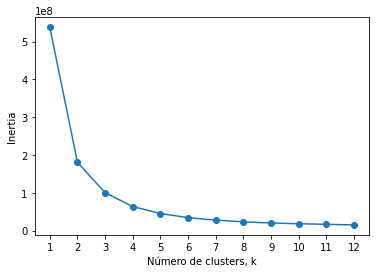

In [61]:
from sklearn.cluster import KMeans
inertias = {k: KMeans(n_clusters=k).fit(X).inertia_ for k in range(1, 13)}

plt.plot(list(inertias.keys()), 
         list(inertias.values()), '-o')
plt.xlabel('Número de clusters, k')
plt.ylabel('Inertia')
plt.xticks(list(inertias.keys()))
plt.show()

# Implementando kmeans

In [62]:
# Implementando kmeans
k = 4
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [63]:
y_pred
y_pred is kmeans.labels_

True

In [64]:
# Coordenadas de los centroides
pd.DataFrame(kmeans.cluster_centers_)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,0.000170,1.087379e-18,0.000723,0.284383,0.000023,0.034281,0.000008,0.007254,0.087961,0.006612,...,0.930912,0.007041,0.384705,0.577519,0.037776,0.012087,0.177267,0.810379,0.000267,0.111794
1,0.000206,2.548329e-06,0.000178,0.219271,0.000008,0.004442,0.000003,0.001249,0.068453,0.000522,...,0.945981,0.004584,0.462932,0.525180,0.011888,0.000650,0.010114,0.989231,0.000005,0.000742
2,0.000125,1.977152e-06,0.000793,0.257933,0.000018,0.017110,0.000006,0.004478,0.072906,0.002968,...,0.919247,0.005421,0.430819,0.546398,0.022783,0.003828,0.054308,0.941799,0.000065,0.022917
3,0.000208,1.170176e-18,0.000583,0.273321,0.000034,0.010493,0.000003,0.003035,0.081471,0.001592,...,0.897005,0.005788,0.438953,0.543633,0.017415,0.001275,0.020065,0.978625,0.000036,0.004632


In [65]:
# NO EJECUTAR
# from sklearn.metrics import silhouette_score
# silhouette_score(X, kmeans.labels_)

In [66]:
X["cluster"] = y_pred
X.head()

,inst_1,inst_2,inst_3,inst_4,inst_5,inst_6,inst_7,inst_8,inst_9,inst_10,...,tabaq_seIgn,otr_caso_si,otr_caso_no,otr_caso_seIgn,uci_si,uci_no,uci_noAplica,uci_noEsp,defunciones,cluster
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,3


# Exportando el dataframe X

# Haciendo una tabla pivote






In [67]:
X_pivot = pd.pivot_table(X, index='cluster')
X_pivot["cluster"] = X_pivot.index
X_pivot.head()

,EDAD,alc_alv,alc_azcap,alc_beniJ,alc_coyo,alc_cuaj,alc_cuauh,alc_gam,alc_iztac,alc_iztap,...,sex_M,tabaq_no,tabaq_seIgn,tabaq_si,uci_no,uci_noAplica,uci_noEsp,uci_si,venusC,cluster
cluster,,,,,,,,,,,,,,,,,,,,,
0,68.055744,0.118410,0.059228,0.050045,0.066737,0.014113,0.062921,0.131394,0.045792,0.142994,...,0.536104,0.930912,0.007041,0.062047,0.177267,0.810379,0.000267,0.012087,0.052029,0
1,17.515665,0.145810,0.053523,0.030549,0.055255,0.019146,0.046558,0.117988,0.037547,0.143496,...,0.518498,0.945981,0.004584,0.049435,0.010114,0.989231,0.000005,0.000650,0.042730,1
2,49.491581,0.125664,0.056647,0.039347,0.061096,0.016290,0.054180,0.127429,0.043994,0.148534,...,0.565673,0.919247,0.005421,0.075331,0.054308,0.941799,0.000065,0.003828,0.046566,2
3,33.194011,0.126197,0.054526,0.042483,0.059923,0.017210,0.057575,0.120818,0.040914,0.149304,...,0.542424,0.897005,0.005788,0.097207,0.020065,0.978625,0.000036,0.001275,0.042964,3


In [68]:
print(X_pivot.shape)
X_pivot.columns

(4, 92)


Index(['EDAD', 'alc_alv', 'alc_azcap', 'alc_beniJ', 'alc_coyo', 'alc_cuaj',
       'alc_cuauh', 'alc_gam', 'alc_iztac', 'alc_iztap', 'alc_magdC',
       'alc_migH', 'alc_milpa', 'alc_noEsp', 'alc_tlah', 'alc_tlalp',
       'alc_xoch', 'asma_no', 'asma_seIgn', 'asma_si', 'cardio_no',
       'cardio_seIgn', 'cardio_si', 'defunciones', 'diabetes_no',
       'diabetes_seIgn', 'diabetes_si', 'embarazo_no', 'embarazo_noAplica',
       'embarazo_seIgn', 'embarazo_si', 'epoc_no', 'epoc_seIgn', 'epoc_si',
       'hipert_no', 'hipert_seIgn', 'hipert_si', 'indigena_no',
       'indigena_noEsp', 'indigena_si', 'inmusupr_no', 'inmusupr_seIgn',
       'inmusupr_si', 'inst_1', 'inst_10', 'inst_11', 'inst_12', 'inst_13',
       'inst_14', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7',
       'inst_8', 'inst_9', 'intub_no', 'intub_noAplica', 'intub_noEsp',
       'intub_si', 'leng_ind_no', 'leng_ind_noEsp', 'leng_ind_si',
       'neumonia_no', 'neumonia_noEsp', 'neumonia_si', 'obesidad_no'

In [69]:
X_pivot[["EDAD", "defunciones", "uci_si", "intub_si", "asma_si", "diabetes_si", "inmusupr_si","indigena_si", "paciente_hosp", "obesidad_si", "renalCr_si"]]

,EDAD,defunciones,uci_si,intub_si,asma_si,diabetes_si,inmusupr_si,indigena_si,paciente_hosp,obesidad_si,renalCr_si
cluster,,,,,,,,,,,
0,68.055744,0.111794,0.012087,0.031706,0.013463,0.234102,0.011627,0.003797,0.189621,0.093536,0.018950
1,17.515665,0.000742,0.000650,0.000558,0.021256,0.004172,0.002110,0.002237,0.010769,0.032364,0.001514
2,49.491581,0.022917,0.003828,0.009299,0.017320,0.107954,0.006374,0.003278,0.058201,0.104902,0.006880
3,33.194011,0.004632,0.001275,0.002221,0.019908,0.020608,0.003083,0.002822,0.021375,0.078701,0.003201


# Análisis de los clusters

In [92]:
"""

Cluster 0 / delta: Es el grupo más vulnerable frente a la viropolítica. Incluye a la población que requirió mayores cuidados intensivos, ser intubada. Tuvo valores mayores de sistema inmunosuprimido, requirió mñas hospitalizaciones. 
Cluster 2 / gamma: Es el segundo grupo más vulnerable a la viropolítica.
Cluster 3 / beta: Es el segundo grupo más capaz de ejercer la viropolítica. Mantiene valorrs bajos para cada condición de riesgo.
Cluster 1 / alpha: Es el grupo más capaz de ejercer la viropolítica. Dados sus bajos valores para cada condición de riesgo, es el grupo menos vulnerable. 

"""

'\n\nCluster 0 / delta: Es el grupo más vulnerable frente a la viropolítica. Incluye a la población que requirió mayores cuidados intensivos, ser intubada. Tuvo valores mayores de sistema inmunosuprimido, requirió mñas hospitalizaciones. \nCluster 2 / gamma: Es el segundo grupo más vulnerable a la viropolítica.\nCluster 3 / beta: Es el segundo grupo más capaz de ejercer la viropolítica. Mantiene valorrs bajos para cada condición de riesgo.\nCluster 1 / alpha: Es el grupo más capaz de ejercer la viropolítica. Dados sus bajos valores para cada condición de riesgo, es el grupo menos vulnerable. \n\n'

In [71]:
import plotly.express as px
fig = px.scatter(X_pivot,
                 x="defunciones",
                 y="paciente_hosp",
                 size="EDAD",
                  template = "plotly_dark",
                 color="cluster", title = "Correlación entre el numero de defunciones y los pacientes hospitalizados por COVID-19")
fig.show()

In [72]:

fig = px.scatter_ternary(X_pivot, 
                         a="diabetes_si", 
                         b="hipert_si", 
                         c="asma_si",
                         size="EDAD",
                         size_max = 20,
                         color  = 'cluster',
                         template = "plotly_dark",
                          title = "Condiciones de coomorbilidad más relevantes en la viropolítica, según los grupos"
                         )
fig.show()

In [73]:
fig = px.scatter_ternary(X_pivot, 
                         a="uci_si", 
                         b="paciente_hosp", 
                         c="intub_si",
                         size="EDAD",
                         size_max = 20,
                         color  = 'cluster',
                         template = "plotly_dark",
                          title = "Condiciones de coomorbilidad más relevantes en la viropolítica, según los grupos"
                         )
fig.show()

In [74]:
fig = px.scatter_3d(X_pivot, x="diabetes_si", y="hipert_si", z='paciente_hosp', template="plotly_dark",
              color="cluster", size="EDAD", size_max=50, title="Clusters para el análisis de la viropolítica")
fig.show()

# Proporcion de clusters para cada alcaldía

In [75]:
print(X.shape)
X.columns

(1743568, 92)


Index(['inst_1', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7',
       'inst_8', 'inst_9', 'inst_10', 'inst_11', 'inst_12', 'inst_13',
       'inst_14', 'sex_M', 'sex_H', 'alc_azcap', 'alc_coyo', 'alc_cuaj',
       'alc_gam', 'alc_iztac', 'alc_iztap', 'alc_magdC', 'alc_milpa',
       'alc_alv', 'alc_tlah', 'alc_tlalp', 'alc_xoch', 'alc_beniJ',
       'alc_cuauh', 'alc_migH', 'venusC', 'alc_noEsp', 'paciente_amb',
       'paciente_hosp', 'intub_si', 'intub_no', 'intub_noAplica',
       'intub_noEsp', 'neumonia_si', 'neumonia_no', 'neumonia_noEsp', 'EDAD',
       'embarazo_si', 'embarazo_no', 'embarazo_noAplica', 'embarazo_seIgn',
       'leng_ind_si', 'leng_ind_no', 'leng_ind_noEsp', 'indigena_si',
       'indigena_no', 'indigena_noEsp', 'diabetes_si', 'diabetes_no',
       'diabetes_seIgn', 'epoc_si', 'epoc_no', 'epoc_seIgn', 'asma_si',
       'asma_no', 'asma_seIgn', 'inmusupr_si', 'inmusupr_no', 'inmusupr_seIgn',
       'hipert_si', 'hipert_no', 'hipert_seIgn', 'otr_com_

In [79]:
# Definiendo un dataframe por aclcaldía

azcapotzalco = pd.DataFrame(X[X["alc_azcap"]==1]["cluster"].value_counts()).reset_index()
azcapotzalco = azcapotzalco.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

alvaroOb = pd.DataFrame(X[X["alc_alv"]==1]["cluster"].value_counts()).reset_index()
alvaroOb = alvaroOb.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

benitoJ = pd.DataFrame(X[X["alc_beniJ"]==1]["cluster"].value_counts()).reset_index()
benitoJ = benitoJ.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

coyoacan = pd.DataFrame(X[X["alc_coyo"]==1]["cluster"].value_counts()).reset_index()
coyoacan = coyoacan.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

cuajimalpa = pd.DataFrame(X[X["alc_cuaj"]==1]["cluster"].value_counts()).reset_index()
cuajimalpa = cuajimalpa.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

cuauhtemoc = pd.DataFrame(X[X["alc_cuauh"]==1]["cluster"].value_counts()).reset_index()
cuauhtemoc = cuauhtemoc.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

gam = pd.DataFrame(X[X["alc_gam"]==1]["cluster"].value_counts()).reset_index()
gam = gam.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

iztacalco = pd.DataFrame(X[X["alc_iztac"]==1]["cluster"].value_counts()).reset_index()
iztacalco = iztacalco.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

iztapalapa = pd.DataFrame(X[X["alc_iztap"]==1]["cluster"].value_counts()).reset_index()
iztapalapa = iztapalapa.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

magdalenaC = pd.DataFrame(X[X["alc_magdC"]==1]["cluster"].value_counts()).reset_index()
magdalenaC = magdalenaC.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

miguelH = pd.DataFrame(X[X["alc_migH"]==1]["cluster"].value_counts()).reset_index()
miguelH = miguelH.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

milpaA = pd.DataFrame(X[X["alc_milpa"]==1]["cluster"].value_counts()).reset_index()
milpaA = milpaA.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

noEspecificado = pd.DataFrame(X[X["alc_noEsp"]==1]["cluster"].value_counts()).reset_index()
noEspecificado = noEspecificado.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

tlahuac = pd.DataFrame(X[X["alc_tlah"]==1]["cluster"].value_counts()).reset_index()
tlahuac = tlahuac.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

tlalpan = pd.DataFrame(X[X["alc_tlalp"]==1]["cluster"].value_counts()).reset_index()
tlalpan = tlalpan.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

venustianoC = pd.DataFrame(X[X["venusC"]==1]["cluster"].value_counts()).reset_index()
venustianoC = venustianoC.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")

xochimilco = pd.DataFrame(X[X["alc_xoch"]==1]["cluster"].value_counts()).reset_index()
xochimilco = xochimilco.rename({"index":"cluster", "cluster":"poblacion"}, axis="columns")


## Graficando resultados

In [97]:
"""

Cluster 0 / delta: Es el grupo más vulnerable frente a la viropolítica. Incluye a la población que requirió mayores cuidados intensivos, ser intubada. Tuvo valores mayores de sistema inmunosuprimido, requirió mñas hospitalizaciones. 
Cluster 2 / gamma: Es el segundo grupo más vulnerable a la viropolítica.
Cluster 3 / beta: Es el segundo grupo más capaz de ejercer la viropolítica. Mantiene valorrs bajos para cada condición de riesgo.
Cluster 1 / alpha: Es el grupo más capaz de ejercer la viropolítica. Dados sus bajos valores para cada condición de riesgo, es el grupo menos vulnerable. 

"""

'\n\nCluster 0 / delta: Es el grupo más vulnerable frente a la viropolítica. Incluye a la población que requirió mayores cuidados intensivos, ser intubada. Tuvo valores mayores de sistema inmunosuprimido, requirió mñas hospitalizaciones. \nCluster 2 / gamma: Es el segundo grupo más vulnerable a la viropolítica.\nCluster 3 / beta: Es el segundo grupo más capaz de ejercer la viropolítica. Mantiene valorrs bajos para cada condición de riesgo.\nCluster 1 / alpha: Es el grupo más capaz de ejercer la viropolítica. Dados sus bajos valores para cada condición de riesgo, es el grupo menos vulnerable. \n\n'

In [94]:
X_pivot.columns

Index(['EDAD', 'alc_alv', 'alc_azcap', 'alc_beniJ', 'alc_coyo', 'alc_cuaj',
       'alc_cuauh', 'alc_gam', 'alc_iztac', 'alc_iztap', 'alc_magdC',
       'alc_migH', 'alc_milpa', 'alc_noEsp', 'alc_tlah', 'alc_tlalp',
       'alc_xoch', 'asma_no', 'asma_seIgn', 'asma_si', 'cardio_no',
       'cardio_seIgn', 'cardio_si', 'defunciones', 'diabetes_no',
       'diabetes_seIgn', 'diabetes_si', 'embarazo_no', 'embarazo_noAplica',
       'embarazo_seIgn', 'embarazo_si', 'epoc_no', 'epoc_seIgn', 'epoc_si',
       'hipert_no', 'hipert_seIgn', 'hipert_si', 'indigena_no',
       'indigena_noEsp', 'indigena_si', 'inmusupr_no', 'inmusupr_seIgn',
       'inmusupr_si', 'inst_1', 'inst_10', 'inst_11', 'inst_12', 'inst_13',
       'inst_14', 'inst_2', 'inst_3', 'inst_4', 'inst_5', 'inst_6', 'inst_7',
       'inst_8', 'inst_9', 'intub_no', 'intub_noAplica', 'intub_noEsp',
       'intub_si', 'leng_ind_no', 'leng_ind_noEsp', 'leng_ind_si',
       'neumonia_no', 'neumonia_noEsp', 'neumonia_si', 'obesidad_no'

In [98]:
resumen = X_pivot[['alc_alv', 'alc_azcap', 'alc_beniJ', 'alc_coyo', 'alc_cuaj',
       'alc_cuauh', 'alc_gam', 'alc_iztac', 'alc_iztap', 'alc_magdC',
       'alc_migH', 'alc_milpa', 'alc_noEsp', 'alc_tlah', 'alc_tlalp',
       'alc_xoch', 'venusC']]
resumen

,alc_alv,alc_azcap,alc_beniJ,alc_coyo,alc_cuaj,alc_cuauh,alc_gam,alc_iztac,alc_iztap,alc_magdC,alc_migH,alc_milpa,alc_noEsp,alc_tlah,alc_tlalp,alc_xoch,venusC
cluster,,,,,,,,,,,,,,,,,
0,0.118410,0.059228,0.050045,0.066737,0.014113,0.062921,0.131394,0.045792,0.142994,0.025485,0.037216,0.017318,0.000008,0.041129,0.088865,0.046318,0.052029
1,0.145810,0.053523,0.030549,0.055255,0.019146,0.046558,0.117988,0.037547,0.143496,0.030909,0.030888,0.026110,0.000005,0.055867,0.107455,0.056163,0.042730
2,0.125664,0.056647,0.039347,0.061096,0.016290,0.054180,0.127429,0.043994,0.148534,0.029112,0.034197,0.020738,0.000002,0.048375,0.094267,0.053563,0.046566
3,0.126197,0.054526,0.042483,0.059923,0.017210,0.057575,0.120818,0.040914,0.149304,0.027712,0.035199,0.021948,0.000007,0.050422,0.098577,0.054221,0.042964


In [145]:
alvaroOb

,cluster,poblacion
0,3,74046
1,2,63558
2,1,57218
3,0,30624


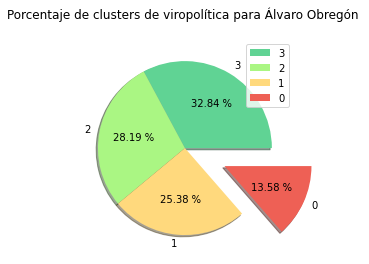

In [154]:
# Alvaro Obregón


conteo = alvaroOb["poblacion"]
etiquetas = alvaroOb["cluster"].unique()
colores = ["#60D394", "#AAF683", "#FFD97D", "#EE6055", "#FF9B85"]
extraccion = 0,0,0,0.5

fig, ax = plt.subplots()
plt.pie(conteo, 
        labels= etiquetas,
        autopct = ("%0.2f %%"),
        colors = colores,
        explode = extraccion, 
        shadow=True)

ax.set_title("Porcentaje de clusters de viropolítica para Álvaro Obregón \n")
ax.legend()
plt.show()


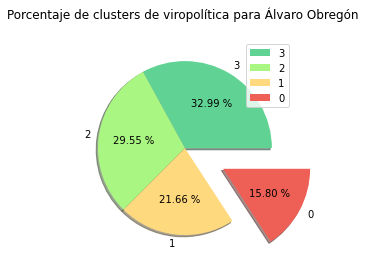

In [155]:
# Azcapotzalco

conteo = azcapotzalco["poblacion"]
etiquetas = azcapotzalco["cluster"].unique()
colores = ["#60D394", "#AAF683", "#FFD97D", "#EE6055", "#FF9B85"]
extraccion = 0,0,0,0.5

fig, ax = plt.subplots()
plt.pie(conteo, 
        labels= etiquetas,
        autopct = ("%0.2f %%"),
        colors = colores,
        explode = extraccion, 
        shadow=True)

ax.set_title("Porcentaje de clusters de viropolítica para Álvaro Obregón \n")
ax.legend()
plt.show()